# LSST SNR Limit

We plot the modeled magnitude of type Ia supernova as a function of phase and wavelength and compare it against the predicted LSST single visit depth (r=24.5 at 5$\sigma$)

In [1]:
from copy import deepcopy

import numpy as np
import sncosmo
from matplotlib import pyplot as plt


In [2]:
def calculate_magnitude(model, phase, redshift, filt):
    """Calculate magnitudes in a given filter
    
    This function is a wrapper for ``model.bandmag`` and
    returns NAN values for phases / redshifts that would
    otherwise raise a ValueError for being out of the model
    range.
    
    Args:
        model    (Model): An sncosmo model
        phase    (array): An array of phase values
        redshift (array): An array of redshift values
        filt       (str): Name of an scnosmo registered filter
        
    Returns:
        A 2d array of magnitudes for each phase / radshift in the given filter
    """
    
    model = deepcopy(model)
    
    mag = []
    for z in redshift:
        model.set(z=z)
        
        try:
            mag.append(model.bandmag(filt, 'ab', phase))
            
        except ValueError:
            mag_this = []
            for p in phase:
                try:
                    mag_this.append(model.bandmag(filt, 'ab', p))

                except ValueError:
                    mag_this.append(np.nan)

            mag.append(mag_this)

    return np.ma.array(mag, mask=np.isnan(mag))


def plot_clabel(cs):
    """Plot labels on figure contours
    
    Args:
        cs: Return of pyplot.contour
    """

    class nf(float):
        def __repr__(self):
            s = f'{self:.1f}'
            return f'{self:.0f}' if s[-1] == '0' else s

    cs.levels = [nf(val) for val in cs.levels]
    plt.clabel(cs, cs.levels, inline=True, fmt='%r', fontsize=10)


We choose to use the `salt2-extended` model built into sncosmo since it allows us to consider higher redshift values.

In [3]:
sn_model = sncosmo.Model('salt2-extended')  # or salt2-extended, salt2-h17
source = sn_model.source
print(f'Model name: {source.name}')
print(f'Model version: {source.version}')
print(f'Phase range: {source.minphase()} - {source.maxphase()}')
print(f'Wave range: {source.minwave()} - {source.maxwave()}')


Model name: salt2-extended
Model version: 2.0
Phase range: -20.0 - 50.0
Wave range: 1700.0 - 24990.0


In [4]:
filter_name = 'lsstr'
redshift_range = (0, 2.2, .01)
phase_range = (-20, 120, .5)

redshift_arr = np.arange(*redshift_range)
phase_arr = np.arange(*phase_range)
mag_arr = calculate_magnitude(sn_model, phase_arr, redshift_arr, filter_name)


/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/anaconda3/envs/cmfgen/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


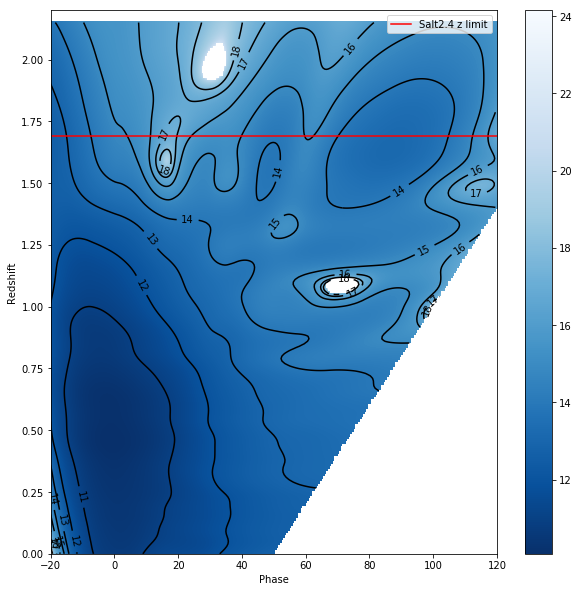

In [5]:
extent = [phase_range[0], phase_range[1], redshift_range[0], redshift_range[1]]
fig = plt.figure(figsize=(10, 10))

plt.imshow(
    mag_arr, 
    origin='lower', 
    interpolation='bilinear',
    cmap='Blues_r', 
    extent=extent, 
    aspect='auto'
)

plt.colorbar()
plt.axhline(1.69, color='red', label='Salt2.4 z limit')
contours = plt.contour(
    phase_arr, 
    redshift_arr, 
    mag_arr, 
    levels=np.arange(10, 19), 
    extent=extent,
    colors='k'
)

plot_clabel(contours)
plt.xlabel('Phase')
plt.ylabel('Redshift')
plt.legend()
plt.show()


# Debugging

Lets stop and check that our `calculate_magnitude` function is returning the correct values

In [6]:
z = .5
p = np.arange(-20, 40)

sn_model.set(z=z)
sncosmo_mag = sn_model.bandmag('lsstr', 'ab', p)
wrapped_mag = calculate_magnitude(sn_model, p, [z], 'lsstr')[0]
all(np.equal(sncosmo_mag, wrapped_mag))


True